# Bitwise information content for all CAMS variables

In [1]:
using BitInformation
using JLD2
path = "/network/aopp/chaos/pred/kloewer/esowc/cams/"
@load joinpath(path,"..","analysis/bitinformation_all.jld2") varnames IC

2-element Vector{Symbol}:
 :varnames
 :IC

# Find bits with information

In [2]:
using Statistics, StatsBase

In [3]:
nvars = length(varnames)

ICfilt = copy(IC)
for i in 1:nvars
    ic = ICfilt[i,:]
    p = BitInformation.binom_confidence(900*440*137,0.99)  # get chance p for 1 (or 0) from binom distr
    M₀ = 1 - entropy([p,1-p],2)                            # free entropy of random 50/50 at trial size
    threshold = max(M₀,1.5*maximum(ic[end-3:end]))         # in case the information never drops to zero
                                                           # use something a bit bigger than maximum 
                                                           # of the last 8 bits
    insigni = (ic .<= threshold) .& (collect(1:length(ic)) .> 9)
    ICfilt[i,insigni] .= floatmin(Float64)
end

In [4]:
ICcsum = cumsum(ICfilt,dims=2)
ICcsum_norm = copy(ICcsum)
for i in 1:nvars
    ICcsum_norm[i,:] ./= ICcsum_norm[i,end]
end

inflevel = 0.99
infbits = [argmax(ICcsum_norm[i,:] .> inflevel) for i in 1:nvars]
infbits100 = [argmax(ICcsum_norm[i,:] .> 0.999999999) for i in 1:nvars];

In [32]:
@save joinpath(path,"../analysis/bits_to_retain.jld2") varnames infbits infbits100

## SORTING / POSTPROCESSING

In [5]:
# sort and group
aero = vcat(1,32,57,collect(2:30))
ozone = [50,60,61]
methane = [42,43,56]
clouds = [38,44,45,48,49,67]
hydro = vcat(collect(51:55),62,31)
nitro = [58,59,68]
oopp = Array(63:66)
ces = vcat(collect(33:37),collect(39:41))
ceshydro = vcat(ces,hydro)
co12 = [46,47]

grouped = vcat(aero,co12,clouds,methane,ces,hydro,nitro,ozone,oopp)
groups = [aero,co12,clouds,methane,ces,hydro,nitro,ozone,oopp];

In [6]:
# shorten "backscat" in varnames
for (i,varname) in enumerate(varnames)
    varnames[i] = replace(varname,"backscat"=>"")
end

In [7]:
# for plotting replace zeros with NaN to get white
ICnan = copy(ICfilt)
ICnan[iszero.(ICfilt)] .= NaN;

In [11]:
# sort
varnames_sorted = varnames[grouped]
infbits_sorted = infbits[grouped]
infbits100_sorted = infbits100[grouped]
ICnan_sorted = ICnan[grouped,:]
ICcsum_sorted = ICcsum[grouped,:]

# for plotting
infbitsx_sorted = copy(vec(hcat(infbits_sorted,infbits_sorted)'))
infbitsx100_sorted = copy(vec(hcat(infbits100_sorted,infbits100_sorted)'))
infbitsy_sorted = copy(vec(hcat(Array(0:nvars-1),Array(1:nvars))'));

## PLOTTING

In [9]:
using ColorSchemes, Printf, PyPlot

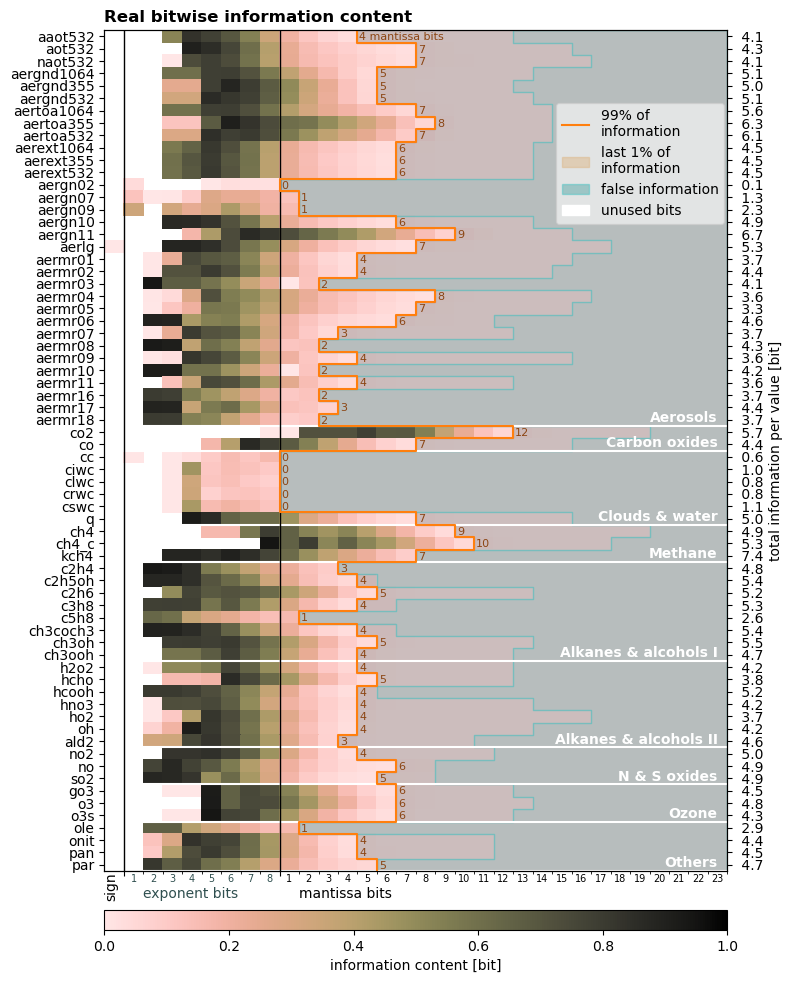

PyObject <matplotlib.legend.Legend object at 0x7f92e0f24b10>

In [13]:
fig,ax1 = subplots(1,1,figsize=(8,10),sharey=true)
ax1.invert_yaxis()
tight_layout(rect=[0.06,0.08,0.93,0.98])
pos = ax1.get_position()
cax = fig.add_axes([pos.x0,0.06,pos.x1-pos.x0,0.02])

ax1right = ax1.twinx()
ax1right.invert_yaxis()

# information
cmap = ColorMap(ColorSchemes.turku.colors).reversed()
pcm = ax1.pcolormesh(ICnan_sorted,vmin=0,vmax=1;cmap)
cbar = colorbar(pcm,cax=cax,orientation="horizontal")
cbar.set_label("information content [bit]")

# 99% of real information enclosed
ax1.plot(vcat(infbits_sorted,infbits_sorted[end]),Array(0:nvars),"C1",ds="steps-pre",zorder=10,label="99% of\ninformation")

# grey shading
ax1.fill_betweenx(infbitsy_sorted,infbitsx_sorted,fill(32,length(infbitsx_sorted)),alpha=0.4,color="grey")
ax1.fill_betweenx(infbitsy_sorted,infbitsx100_sorted,fill(32,length(infbitsx_sorted)),alpha=0.1,color="c")
ax1.fill_betweenx(infbitsy_sorted,infbitsx100_sorted,fill(32,length(infbitsx_sorted)),alpha=0.3,facecolor="none",edgecolor="c")

# for legend only
ax1.fill_betweenx([-1,-1],[-1,-1],[-1,-1],color="burlywood",label="last 1% of\ninformation",alpha=.5)
ax1.fill_betweenx([-1,-1],[-1,-1],[-1,-1],facecolor="teal",edgecolor="c",label="false information",alpha=.3)
ax1.fill_betweenx([-1,-1],[-1,-1],[-1,-1],color="w",label="unused bits")

ax1.axvline(1,color="k",lw=1,zorder=3)
ax1.axvline(9,color="k",lw=1,zorder=3)

grouplabls = ["Aerosols","Carbon oxides","Clouds & water",
                "Methane","Alkanes & alcohols I","Alkanes & alcohols II",
                "N & S oxides","Ozone","Others"]

for (ig,group) in enumerate(groups)
    y = sum([length(g) for g in groups[1:ig]])
    ax1.axhline(y,color="w",lw=1.5,zorder=2)
    ax1.text(31.5,y-0.3,grouplabls[ig],color="w",ha="right",fontweight="bold")
end

ax1.set_title("Real bitwise information content",loc="left",fontweight="bold")

ax1.set_xlim(0,32)
ax1.set_ylim(nvars,0)
ax1right.set_ylim(nvars,0)

ax1.set_yticks(Array(1:nvars).-0.5)
ax1right.set_yticks(Array(1:nvars).-0.5)
ax1.set_yticklabels(varnames_sorted)
ax1right.set_yticklabels([@sprintf "%4.1f" i for i in ICcsum_sorted[:,end]])
ax1right.set_ylabel("total information per value [bit]")

ax1.text(infbits_sorted[1]+0.1,0.8,"$(infbits[1]-9) mantissa bits",fontsize=8,color="saddlebrown")
for i in 2:nvars
    ax1.text(infbits_sorted[i]+0.1,(i-1)+0.8,"$(infbits_sorted[i]-9)",fontsize=8,color="saddlebrown")
end

ax1.set_xticks([1,9])
ax1.set_xticks(vcat(2:8,10:32),minor=true)
ax1.set_xticklabels([])
ax1.text(0,nvars+2.2,"sign",rotation=90)
ax1.text(2,nvars+2.2,"exponent bits",color="darkslategrey")
ax1.text(10,nvars+2.2,"mantissa bits")

for i in 1:8
    ax1.text(i+.5,nvars+0.9,"$i",ha="center",fontsize=7,color="darkslategrey")
end

for i in 1:23
    ax1.text(8+i+.5,nvars+0.9,"$i",ha="center",fontsize=7)
end
    
ax1.legend(loc=(0.725,0.77),framealpha=0.6)

# savefig("../plots/bitinformation_all.png",dpi=100)

In [40]:
kch4 = IC[varnames .== "kch4",:][:]

32-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.8839020681474308
 0.8839020681474308
 0.84640161553342
 0.9017268900902362
 0.8509884189364086
 0.7663341158682232
 0.6198489678249429
 0.48147456180774234
 0.38320519012334914
 0.29505288794145706
 ⋮
 0.04916977622130314
 0.04880299473410121
 0.0482860315623392
 0.04741501439991278
 0.046911397775675746
 0.04682540210700337
 0.04683671541968615
 0.04718929555440676
 0.046420401778314045
 0.04647157091258808
 0.04641513379066514
 0.046515055490257494

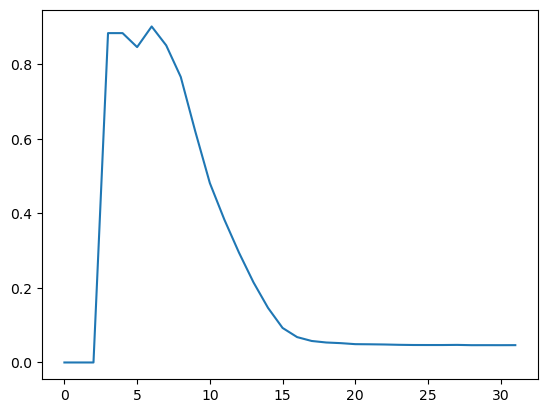

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd691956d10>

In [41]:
plot(kch4)